### iTerms: Deconstructing ToS with LLMs
Defining legal requirements as code enables users to automatically and more efficiently assess compliance with service restrictions. However, non-technical users face significant challenges when translating and understanding these clauses in existing formal languages. With iTerms, we propose a first approach that leverages LLMs as a bridge to translate Terms of Service clauses into the Terms of Service Language (TOSL).

In [2]:
! pip install langchain
! pip install langchain-openai
! pip install langchain-community
! pip install langchain-core
! pip install pdfplumber
! pip install rdflib requests
! pip install -U "openai>=1.46.0" "langchain>=0.2.12" "langchain-core>=0.2.34" "langchain-openai>=0.1.20"

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Using cached openai-2.0.0-py3-none-any.whl.metadata (29 kB)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import json
import key
from langchain_openai import ChatOpenAI

api_key = key.APIKEY
model = ChatOpenAI(openai_api_key = api_key,base_url = "https://openrouter.ai/api/v1",
        model_name = "mistralai/mistral-small-3.2-24b-instruct:free", temperature=0)

# Knowledge Graph Construction

## Phase 2: Turtle Generation Guided by Template and Ontology

The second phase focuses on transforming the enriched representation into an interoperable semantic format.  

- **Inputs:** enriched use case, a Markdown-based template serving as a construction guide, and the TOSL/ODRL ontology as a semantic reference  
- **Processing:** application of the template and the metamodel to generate RDF statements in Turtle syntax  
- **Output:** Turtle file corresponding to the processed clause  

In [4]:
def load_use_cases(json_path):
    """
    Carga el JSON y devuelve una lista de diccionarios con los campos relevantes.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    global_metadata = {
        "PROVIDER": data.get("PROVIDER", "Unknown"),
        "SOURCE": data.get("SOURCE", "Unknown"),
        "TITLE": data.get("TITLE", "Unknown"),
        "DATE": data.get("DATE", "Unknown")
    }

    use_cases = []
    for key, item in data.get("USE_CASE_DESCRIPTIONS", {}).items():
        clause = item.get("description", "").strip()
        use_cases.append({
            "id": key,
            "clause": clause,
        })

    return use_cases, global_metadata

In [5]:
def extract_text_from_md(md_path):
  with open(md_path, "r", encoding="utf-8") as f:
      content = f.read()
  return content

In [6]:
def extract_ttl(content):
    start_tag = "```ttl"
    end_tag = "```"
    start_idx = content.find(start_tag)
    end_idx = content.rfind(end_tag)

    if start_idx == -1 or end_idx == -1:
        raise ValueError("No se encontraron los delimitadores ```ttl")

    # Extraer solo la parte del TTL
    ttl = content[start_idx + len(start_tag):end_idx].strip()
    return ttl

In [7]:
def save_prompt(prompt_text, uc_id):
    path = f"phase2/results/prompt-{uc_id}.txt"
    with open(path, "w") as f:
        f.write(prompt_text)

def save_ttl(ttl_text, uc_id):
    path = f"phase2/results/{uc_id}.ttl"
    with open(path, "w", encoding="utf-8") as f:
        f.write(ttl_text)

In [8]:
# Función para manejar el límite de tasa *general* y agregar un mínimo retraso
import time
def manage_rate_limit_and_delay(api_call_count, start_time, limit=5, time_window=70, min_delay_between_calls=1):
    """
    Gestiona el límite de llamadas a la API dentro de una ventana de tiempo
    Y asegura un retraso mínimo entre llamadas permitidas.
    Esta función *no* reintenta, solo espera para respetar el ritmo.

    Args:
      api_call_count: Número actual de llamadas en la ventana.
      start_time: Tiempo de inicio de la ventana actual.
      limit: Límite de llamadas por ventana.
      time_window: Duración de la ventana en segundos.
      min_delay_between_calls: Retraso mínimo en segundos a esperar antes de proceder.

    Returns:
      Una tupla con el nuevo api_call_count y start_time.
    """
    current_time = time.time()
    elapsed_time = current_time - start_time

    # Primero, verificar si la ventana anterior ha expirado.
    if elapsed_time >= time_window:
        # Si la ventana expiró, reiniciamos el contador y el tiempo.
        # Aplicamos el retraso mínimo antes de iniciar la nueva ventana con la llamada actual.
        print(f"Ventana de tiempo ({time_window}s) expirada desde start_time ({start_time:.2f}). Reiniciando contador. Aplicando retraso mínimo de {min_delay_between_calls}s.")
        time.sleep(min_delay_between_calls)
        return 1, time.time() # Nueva ventana comienza ahora

    # Si aún estamos dentro de la ventana y hemos alcanzado o superado el límite
    if api_call_count >= limit:
        time_to_wait = time_window - elapsed_time
        if time_to_wait > 0:
            print(f"Límite de {limit} llamadas alcanzado ({api_call_count}). Esperando {time_to_wait:.2f} segundos. Aplicando retraso mínimo de {min_delay_between_calls}s después de la espera.")
            time.sleep(time_to_wait)
            # Después de esperar por la ventana, una nueva comienza. Aplicar retraso mínimo.
            time.sleep(min_delay_between_calls)
            return 1, time.time() # Nueva ventana comienza ahora
        else:
             # Esto no debería ocurrir si elapsed_time >= time_window se manejó arriba.
             # Pero como fallback:
             print(f"Límite alcanzado, pero ventana ya expirada. Aplicando retraso mínimo de {min_delay_between_calls}s. Reiniciando contador.")
             time.sleep(min_delay_between_calls)
             return 1, time.time()
    else:
        # Si no se alcanzó el límite y estamos dentro de la ventana,
        # simplemente aplicamos el retraso mínimo antes de proceder con la llamada actual.
        print(f"Dentro de la ventana. Aplicando retraso mínimo de {min_delay_between_calls}s. Llamada #{api_call_count + 1}")
        time.sleep(min_delay_between_calls)
        # Incrementa el contador y actualiza el tiempo de inicio a justo después de la espera MÍNIMA.
        # Esto hace que la siguiente llamada calcule su espera desde este punto.
        return api_call_count + 1, time.time()

In [9]:
def build_prompt(template_text, clause_info, global_metadata):
    """
    Construye un prompt de modelado RDF en Turtle.
    """
    prompt = f"""
        You are a legal knowledge extractor specialized in TOSL and ODRL policy modeling.

        TASKS:
        - Read the clause.
        - Produce a SINGLE minimal ODRL/TOSL policy in Turtle.

        Guidelines:
        - Output MUST be valid Turtle inside a single fenced code block: ```ttl … ```
        - Use only the vocabulary and structure provided in the reference template in markdown.
        - Use ONLY the classes, properties, prefixes, and shapes that appear in the reference template below.
        - All URIs and prefixes must be exactly as shown.
        - Do not add explanations, headers, or any commentary.

        Reference template: 
        {template_text}

        Metadata:
          - Provider: {global_metadata.get("PROVIDER", "Unknown")}
          - Source: {global_metadata.get("SOURCE", "Unknown")}
          - Title: {global_metadata.get("TITLE", "Unknown")}
          - Date: {global_metadata.get("DATE", "Unknown")}

        Clause to model: {clause_info['clause']}
        """
    return prompt.strip()


def main(json_path, md_path):
    """
    Orquesta el flujo:
    1. Lee JSON.
    2. Lee template markdown.
    3. Construye prompts para cada cláusula.
    """
    use_cases, global_metadata = load_use_cases(json_path)
    tosl_guidelines_text = extract_text_from_md(md_path)
    os.makedirs("phase2/results", exist_ok=True)

    # Inicializa el contador y el tiempo para la gestión del límite de tasa general
    api_call_count_global = 0
    start_time_global = time.time()

    # Configura los límites de la API y retraso mínimo
    API_LIMIT = 15
    TIME_WINDOW = 70
    MIN_DELAY = 1 # Segundos de retraso mínimo entre *cualquier* llamada permitida    

    for uc in use_cases:
      prompt_text = build_prompt(tosl_guidelines_text, uc, global_metadata)
      save_prompt(prompt_text, uc['id'])
      messages = [
          {"role": "system", "content": "You are a legal knowledge extractor specialized in TOSL and ODRL policy modeling."},
          {"role": "user", "content": prompt_text}
      ]

      # Gestiona el límite general ANTES de intentar la llamada (incluyendo reintentos de tenacity)
      api_call_count_global, start_time_global = manage_rate_limit_and_delay(api_call_count_global, start_time_global, limit=API_LIMIT, time_window=TIME_WINDOW, min_delay_between_calls=MIN_DELAY)      

      response = model.invoke(messages)

      print("======================================")
      print(f"{uc['id']}")
      print("======================================")
      print(response.content)
      ttl_text = extract_ttl(response.content)
      save_ttl(ttl_text, uc['id'])
      print(f"✅ Archivo guardado")
      print("\n\n")


In [10]:
if __name__ == "__main__":
    json_path = "../data/use_cases_elsevier.json"
    md_path = "../metamodel/tosl_guidelines.md"

    main(json_path, md_path)

Dentro de la ventana. Aplicando retraso mínimo de 1s. Llamada #1
use_case_1
```ttl
@prefix : <http://example.com/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix odrl: <http://www.w3.org/ns/odrl/2/> .
@prefix tosl: <https://w3id.org/tosl/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:obligation01 a odrl:Duty ;
    dcterms:description "You confirm that You have the right and authority to enter into this Agreement." ;
    odrl:action tosl:consent ;
    odrl:target :agreement01 ;
    odrl:assignee :customer .
```
✅ Archivo guardado



Dentro de la ventana. Aplicando retraso mínimo de 1s. Llamada #2
use_case_2
```ttl
@prefix : <http://example.com/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix odrl: <http://www.w3.org/ns/odrl/2/> .
@prefix tosl: <https://w3id.org/tosl/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:agreement01 a odrl:Agreement ;
    dcterms:source <https://dev.elsevier.com/api_service_agreement.html> ;
    dcterms:title "API SERVICE 

#### Evaluation Phase II

In Phase II of the pipeline, we work with the first version of the clause representation in TTL. Our validation focuses on checking whether the generated TTL contains any syntax or semantic errors according to the TOSL language, using the validator available at [https://tosl.onrender.com/docs](https://tosl.onrender.com/docs). This process provides a detailed list of typing issues and missing mandatory attributes in the representation. Based on this, we calculate the percentage of use cases that successfully pass the validation and analyse the range of errors found in those that do not have a correct construction.

In [11]:
import requests

PREFIXES = {
    "http://www.w3.org/ns/shacl#": "sh:",
    "http://www.w3.org/ns/odrl/2/": "odrl:",
    "https://w3id.org/tosl/": "tosl:",
    "http://example.com/": ":",
    "http://www.w3.org/2001/XMLSchema#": "xsd:",
}
def short(u: str) -> str:
    if not u:
        return ""
    for base, pfx in PREFIXES.items():
        if u.startswith(base):
            return pfx + u[len(base):]
    return u

def tosl_checker(url, file_path):
    with open(file_path, "rb") as f:
        r = requests.post(url, files={"file": ("use_case.ttl", f, "text/turtle")})

    print("Código de estado:", r.status_code)
    try:
        data = r.json()
    except Exception:
        print("Respuesta no-JSON:\n", r.text)
        return None

    ok = bool(data.get("conforms") or data.get("valid"))
    print("✅ Conforms" if ok else "❌ Violations")

    if ok:
        return data

    for i, v in enumerate(data.get("violations", []), 1):
        focus = short(v.get("focusNode", ""))
        path  = short(v.get("resultPath", ""))
        value = short(v.get("valueNode", ""))
        msg   = v.get("message", "")
        head = f"{focus} --{path}--> {value}" if path else focus or value or "(sin nodo)"
        print(f"  {i}. {head}")
        if msg:
            print(f"      {msg}")

    return data


[i] phase2\results\use_case_1.ttl
Código de estado: 200
❌ Violations
  1. :obligation01 --odrl:target--> :agreement01
      Target must be of type odrl:Asset, tosl:Service, or tosl:UserContent.
  2. :agreement01
      Target must be of type odrl:Asset, tosl:Service, or tosl:UserContent.
  3. :obligation01 --odrl:assignee--> :customer
      The assignee must be a tosl:Provider, tosl:Customer, or tosl:BusinessCustomer.
  4. :customer
      Node :customer must conform to one or more shapes in [ sh:class tosl:Provider ] , [ sh:class tosl:Customer ] , [ sh:class tosl:BusinessCustomer ]

[i] phase2\results\use_case_10.ttl
Código de estado: 200
❌ Violations
  1. :prohibition01 --odrl:assignee--> :application
      The assignee must be a tosl:Provider, tosl:Customer, or tosl:BusinessCustomer.
  2. :application
      Node :application must conform to one or more shapes in [ sh:class tosl:Provider ] , [ sh:class tosl:Customer ] , [ sh:class tosl:BusinessCustomer ]
  3. :prohibition01 --odrl:tar

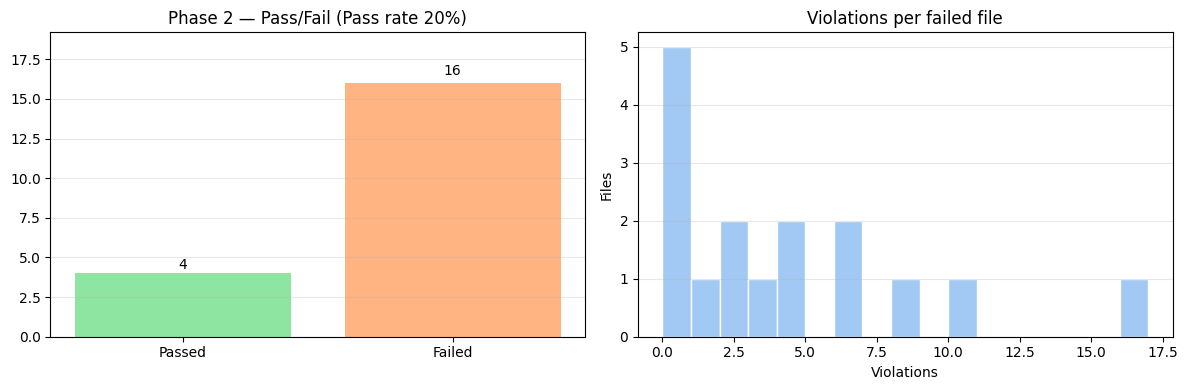

In [12]:
import json, pathlib
import matplotlib.pyplot as plt

VALIDATOR_URL = "https://tosl.onrender.com/validator/validate"

def phase2_validate_and_plot( url: str = VALIDATOR_URL, in_globs = ("phase2/results/*.ttl",), out_json: str = "phase2/eval/elsevier_ttls_results.json",
    out_plot: str = "phase2/eval/elsevier_ttls_results_plot.png", show_hist: bool = True):

    paths = []
    for g in in_globs:
        paths.extend(pathlib.Path(".").glob(g))
    paths = sorted(set(paths), key=lambda p: str(p))

    out_path = pathlib.Path(out_json)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    pathlib.Path(out_plot).parent.mkdir(parents=True, exist_ok=True)

    results = {}
    for p in paths:
        print(f"\n[i] {p}")
        report = tosl_checker(url, str(p)) or {}
        passed = bool(report.get("conforms") or report.get("valid"))
        errors = len(report.get("violations", [])) if isinstance(report, dict) else None
        results[str(p)] = {"passed": passed, "errors": errors}

    out_path.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"\nSaved JSON: {out_path} ({len(results)} items)")

    if isinstance(results, dict):
        vals = list(results.values())
    elif isinstance(results, list):
        vals = results
    else:
        raise TypeError(f"Unsupported results type: {type(results).__name__}")
    passed_n = sum(1 for v in vals if v.get("passed"))
    failed_n = len(vals) - passed_n
    pass_rate = (passed_n / (passed_n + failed_n) * 100) if (passed_n + failed_n) else 0.0

    c_pass, c_fail, c_hist = "#8de5a1", "#ffb482", "#a1c9f4"

    if show_hist:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(7, 4))

    ax0.bar(["Passed", "Failed"], [passed_n, failed_n], color=[c_pass, c_fail])
    for i, v in enumerate([passed_n, failed_n]):
        ax0.text(i, v + max(1, v) * 0.02, f"{v}", ha="center", va="bottom", fontsize=10)
    ax0.set_ylim(0, max(1, passed_n, failed_n) * 1.2)
    ax0.set_title(f"Phase 2 — Pass/Fail (Pass rate {pass_rate:.0f}%)")
    ax0.grid(axis="y", alpha=0.3)

    if show_hist:
        errors = [int(v.get("errors") or 0) for v in vals if not v.get("passed")]
        if errors:
            bins = range(0, max(errors) + 2)
            ax1.hist(errors, bins=bins, color=c_hist, edgecolor="white")
            ax1.set_title("Violations per failed file")
            ax1.set_xlabel("Violations")
            ax1.set_ylabel("Files")
            ax1.grid(axis="y", alpha=0.3)
        else:
            ax1.axis("off")
            ax1.text(0.5, 0.5, "No failed files", ha="center", va="center", fontsize=11)

    plt.tight_layout()
    plt.savefig(out_plot, dpi=160)
    print(f"Saved plot: {out_plot}")
    plt.show()

    return results

if __name__ == "__main__":
    phase2_validate_and_plot()


-------

## Phase 3: Validation and Self-repair
This phase ensures the syntactic and semantic correctness of the output.  

- **Input:** Turtle file generated in the previous phase  
- **Processing:**  
  - Syntactic validation using standard Turtle validation tools  
  - Semantic validation using a custom validator based on TOSL/ODRL rules  
  - **AI-assisted self-repair** to automatically correct inconsistencies  
- **Outputs:**  
  1. Error report  
  2. Corrected and validated Turtle file  

In [13]:
def build_prompt_fix_ttl(template_text, instance_ttl, validator_errors_json):
    """
    Builds a prompt to FIX a Turtle file using an ontology and validator feedback.
    Output is requested as a fenced ```ttl code block.
    """
    prompt = f"""
        You are a knowledge engineer specialized in RDF/Turtle and ontology-driven validation.

        Tasks:
        - Read the original Turtle file and the validator violations.
        - Fix ALL violations so that the file conforms to the given TOSL guidelines.
        - Preserve all correct information and the original meaning whenever possible.

        Guidelines:
        - Output MUST be valid Turtle inside a single fenced code block: ```ttl … ```
        - Use only the vocabulary and structure provided in the reference template in markdown.
        - Use ONLY the classes, properties, prefixes, and shapes that appear in the reference template below.
        - All URIs and prefixes must be exactly as shown.
        - Do not add explanations, headers, or any commentary.
        - Be careful and not introduce new errors.

        Reference template: 
        {template_text}

        Validator errors (JSON):
        {validator_errors_json}

        Original file (Turtle):
        {instance_ttl}

        IMPORTANT:
        - Think step by step internally, but return ONLY the corrected Turtle in a ```ttl fenced block.
    """
    return prompt.strip()


In [14]:
import json
from pathlib import Path

URL = "https://tosl.onrender.com/validator/validate"
IN_DIR = Path("phase2/results")
OUT_DIR = Path("phase3/results")
EVAL_JSON = Path("phase3/eval/elsevier_ttls_results.json")
GUIDELINES_PATH = Path("../metamodel/tosl_guidelines.md")

def _violations_count(report):
    if isinstance(report, dict) and isinstance(report.get("violations"), list):
        return len(report["violations"])
    return 0

def _save_results(path: Path, results):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")

def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    EVAL_JSON.parent.mkdir(parents=True, exist_ok=True)

    template_text = extract_text_from_md(str(GUIDELINES_PATH))

    phase3_results = []

    for i in range(1, 21):
        in_file = IN_DIR / f"use_case_{i}.ttl"
        out_file = OUT_DIR / f"use_case_{i}.ttl"

        print(f"[i] use_case_{i}.ttl")

        if not in_file.exists():
            phase3_results.append({
                "file": in_file.name,
                "outfile": str(out_file),
                "passed": False,
                "errors": 1,
                "report": {"error": "Missing input TTL in phase2/results"}
            })
            continue

        report_phase2 = tosl_checker(URL, str(in_file))
        ok_phase2 = bool(report_phase2.get("conforms") or report_phase2.get("valid"))

        if ok_phase2:
            out_file.write_text(in_file.read_text(encoding="utf-8"), encoding="utf-8")
            print(f"    ✅ Conforms (fase 2) | Copiado a fase 3: {out_file.name}")
        else:
            prompt_text = build_prompt_fix_ttl(
                template_text=template_text,
                instance_ttl=in_file.read_text(encoding="utf-8"),
                validator_errors_json=report_phase2.get("violations", []),
            )
            messages = [
                {"role": "system", "content": "You are a strict RDF/Turtle engineer."},
                {"role": "user", "content": prompt_text},
            ]
            response = model.invoke(messages)
            ttl_text = extract_ttl(response.content)
            out_file.write_text(ttl_text, encoding="utf-8")
            print(f"    Generado fix → {out_file.name}")

        report_phase3 = tosl_checker(URL, str(out_file))
        ok_phase3 = bool(report_phase3.get("conforms") or report_phase3.get("valid"))
        errs_phase3 = _violations_count(report_phase3)

        phase3_results.append({
            "file": in_file.name,
            "outfile": str(out_file),
            "passed": ok_phase3,
            "errors": errs_phase3,
            "report": report_phase3,
        })

        print("Resultado fase 3:", "✅ Conforms" if ok_phase3 else f"❌ No conforms ({errs_phase3} violations)")

    _save_results(EVAL_JSON, phase3_results)
    print(f"\n[✓] JSON guardado con SOLO fase 3 (ordenado): {EVAL_JSON}")

if __name__ == "__main__":
    main()


[i] use_case_1.ttl
Código de estado: 200
❌ Violations
  1. :obligation01 --odrl:assignee--> :customer
      The assignee must be a tosl:Provider, tosl:Customer, or tosl:BusinessCustomer.
  2. :customer
      Node :customer must conform to one or more shapes in [ sh:class tosl:Provider ] , [ sh:class tosl:Customer ] , [ sh:class tosl:BusinessCustomer ]
  3. :obligation01 --odrl:target--> :agreement01
      Target must be of type odrl:Asset, tosl:Service, or tosl:UserContent.
  4. :agreement01
      Target must be of type odrl:Asset, tosl:Service, or tosl:UserContent.
    Generado fix → use_case_1.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_2.ttl
Código de estado: 200
❌ Violations
    Generado fix → use_case_2.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_3.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_3.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_

#### Evaluation Phase III

 The evaluation of this phase consists of running the TOSL validator ([https://tosl.onrender.com/docs](https://tosl.onrender.com/docs)) again to verify whether the errors have been successfully corrected.

In [15]:
import json, pathlib
import matplotlib.pyplot as plt

def plot_results(results_path, out_plot=None, show_hist=True, title_prefix="Phase 3"):
    if isinstance(results_path, (str, pathlib.Path)):
        results = json.loads(pathlib.Path(results_path).read_text(encoding="utf-8"))
    else:
        results = results_path

    def _pe(v):
        if "passed" in v:
            return bool(v.get("passed")), int(v.get("errors") or 0)
        if "after_fix" in v:
            return bool(v["after_fix"].get("passed")), int(v["after_fix"].get("errors") or 0)
        if "initial" in v:
            return bool(v["initial"].get("passed")), int(v["initial"].get("errors") or 0)
        return False, 0

    vals = results if isinstance(results, list) else list(results.values())
    flags, errs_failed = [], []
    for v in vals:
        p, e = _pe(v)
        flags.append(p)
        if not p:
            errs_failed.append(e)

    passed_n = sum(1 for p in flags if p)
    failed_n = len(flags) - passed_n
    pass_rate = (passed_n / (passed_n + failed_n) * 100) if (passed_n + failed_n) else 0.0

    # 3) Colores y layout idénticos
    c_pass, c_fail, c_hist = "#8de5a1", "#ffb482", "#a1c9f4"

    if show_hist:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(7, 4))

    # Barras Passed/Failed
    ax0.bar(["Passed", "Failed"], [passed_n, failed_n], color=[c_pass, c_fail])
    for i, v in enumerate([passed_n, failed_n]):
        ax0.text(i, v + max(1, v) * 0.02, f"{v}", ha="center", va="bottom", fontsize=10)
    ax0.set_ylim(0, max(1, passed_n, failed_n) * 1.2)
    ax0.set_title(f"{title_prefix} — Pass/Fail (Pass rate {pass_rate:.0f}%)")
    ax0.grid(axis="y", alpha=0.3)

    # Histograma de violaciones por archivo fallido
    if show_hist:
        if errs_failed:
            bins = range(0, max(errs_failed) + 2)
            ax1.hist(errs_failed, bins=bins, color=c_hist, edgecolor="white")
            ax1.set_title("Violations per failed file")
            ax1.set_xlabel("Violations")
            ax1.set_ylabel("Files")
            ax1.grid(axis="y", alpha=0.3)
        else:
            ax1.axis("off")
            ax1.text(0.5, 0.5, "No failed files", ha="center", va="center", fontsize=11)

    plt.tight_layout()
    if out_plot:
        pathlib.Path(out_plot).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_plot, dpi=160)
        print(f"Saved plot: {out_plot}")
    plt.show()

    return {"passed": passed_n, "failed": failed_n, "total": len(flags), "pass_rate": pass_rate}


Saved plot: phase3/eval/elsevier_refactor_ttls_results_plot.png


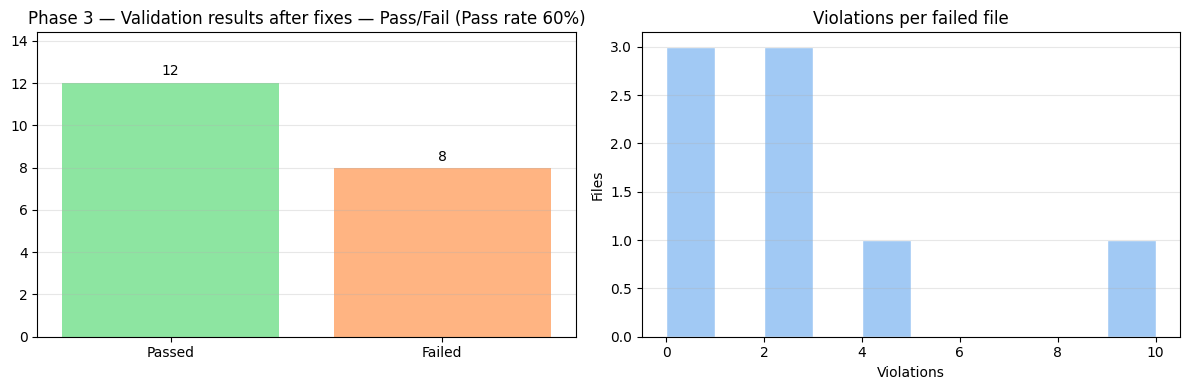

{'passed': 12, 'failed': 8, 'total': 20, 'pass_rate': 60.0}

In [16]:
plot_results("phase3/eval/elsevier_ttls_results.json",
                        out_plot="phase3/eval/elsevier_refactor_ttls_results_plot.png",
                        show_hist=True,
                        title_prefix="Phase 3 — Validation results after fixes")


------

# SPARQL queries

- Deontic modalities 
- Potentially unfair terms


In [ ]:
import json, time, pathlib, concurrent.futures as cf
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

DEONTIC_URL = "https://tosl.onrender.com/sparql/deontic_status"
UNFAIR_URL  = "https://tosl.onrender.com/sparql/unfair_terms"

DEONTIC_KEEP = ["get_duties", "get_permissions", "get_prohibitions", "total_rules"]

TERM_TYPES = [
    "change",
    "termination",
    "contract_by_use",
    "choice_of_law",
    "jurisdiction",
    "arbitration",
    "content_removal",
    "limitation_of_liability",
]

SHORTEN = True
PREFIXES = {
    "http://www.w3.org/ns/odrl/2/": "odrl:",
    "https://w3id.org/tosl/": "tosl:",
    "http://purl.org/dc/terms/": "dcterms:",
    "http://example.com/": ":",
    "http://www.w3.org/2001/XMLSchema#": "xsd:",
}

S = requests.Session()
S.headers.update({"Accept": "application/sparql-results+json", "Accept-Encoding": "gzip, deflate"})
S.mount("https://", HTTPAdapter(max_retries=Retry(
    total=3, backoff_factor=0.6, status_forcelist=[429, 500, 502, 503, 504], allowed_methods=["POST"]
)))
TIMEOUT = 60

def short(u: str):
    if not SHORTEN or not isinstance(u, str):
        return u
    for base, pfx in PREFIXES.items():
        if u.startswith(base):
            return pfx + u[len(base):]
    return u

def to_rows(payload):
    if isinstance(payload, list):
        return payload
    if isinstance(payload, dict) and "results" in payload:
        vars_ = payload.get("head", {}).get("vars", [])
        return [{v: b.get(v, {}).get("value") for v in payload["results"].get("bindings", [])}
                for b in payload["results"].get("bindings", [])]
    return []

def as_list(x):
    if x is None or x == "":
        return []
    if isinstance(x, list):
        return [short(v) for v in x]
    return [short(v.strip()) for v in str(x).split(",") if v.strip()]

def norm_deontic_row(row):
    rid = row.get("duty") or row.get("permission") or row.get("prohibition") or row.get("rule") or row.get("element")
    return {
        "id": short(rid),
        "actions": as_list(row.get("actions") or row.get("action")),
        "targets": as_list(row.get("targets") or row.get("target")),
        "assignee": short(row.get("assignee")),
        "assigner": short(row.get("assigner")),
        "description": row.get("description"),
    }

def post_file(url, ttl_path, params=None):
    t0 = time.time()
    ttl_path = pathlib.Path(ttl_path)
    with open(ttl_path, "rb") as f:
        r = S.post(url, params=params or {}, files={"file": (ttl_path.name, f, "text/turtle")}, timeout=TIMEOUT)
    ms = int((time.time() - t0) * 1000)
    try:
        data, ok_json = r.json(), True
    except Exception:
        data, ok_json = {"non_json": r.text[:4000]}, False
    return {"status": r.status_code, "ms": ms, "ok": r.ok and ok_json, "data": data}

def run_all_for_file(ttl_path: str):
    ttl_path = str(ttl_path)
    out = {
        "file": ttl_path,
        "deontic": {
            "total_rules": 0,
            "duties": [],
            "permissions": [],
            "prohibitions": [],
        },
        "unfair_terms": {},
        "_meta": {"calls": 0, "ok": 0, "ms_total": 0}, 
    }

    for q in DEONTIC_KEEP:
        res = post_file(DEONTIC_URL, ttl_path, params={"deontic_status": q})
        out["_meta"]["calls"] += 1
        out["_meta"]["ok"] += int(bool(res["ok"]))
        out["_meta"]["ms_total"] += res["ms"]
        rows = to_rows(res["data"]) if res["ok"] else []
        if q == "total_rules":
            val = 0
            if rows:
                raw = rows[0].get("totalElements")
                try: val = int(raw or 0)
                except Exception: val = 0
            out["deontic"]["total_rules"] = val
        elif q == "get_duties":
            out["deontic"]["duties"] = [norm_deontic_row(r) for r in rows]
        elif q == "get_permissions":
            out["deontic"]["permissions"] = [norm_deontic_row(r) for r in rows]
        elif q == "get_prohibitions":
            out["deontic"]["prohibitions"] = [norm_deontic_row(r) for r in rows]

    for tt in TERM_TYPES:
        res = post_file(UNFAIR_URL, ttl_path, params={"term_type": tt})
        out["_meta"]["calls"] += 1
        out["_meta"]["ok"] += int(bool(res["ok"]))
        out["_meta"]["ms_total"] += res["ms"]
        rows = to_rows(res["data"]) if res["ok"] else []
        clean = []
        for r in rows:
            clean.append({k: (as_list(v) if k in ("actions", "targets") else short(v)) for k, v in r.items()})
        out["unfair_terms"][tt] = clean

    return out

def run_batch(in_glob="phase3/results/*.ttl", out_dir="evaluation", max_workers=6):
    in_paths = sorted(pathlib.Path(".").glob(in_glob))
    out_dir = pathlib.Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    def _save(res: dict):
        p = pathlib.Path(res["file"])
        out_path = out_dir / f"{p.stem}_results.json"
        out_path.write_text(json.dumps(res, ensure_ascii=False, indent=2))
        return out_path

    index = []
    with cf.ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(run_all_for_file, str(p)): str(p) for p in in_paths}
        for fut in cf.as_completed(futs):
            res = fut.result()
            saved = _save(res)
            index.append({"file": res["file"], "out": str(saved), "calls": res["_meta"]["calls"], "ok": res["_meta"]["ok"]})
            print(f"✓ {res['file']} -> {saved.name} | {res['_meta']['ok']}/{res['_meta']['calls']} OK")

    (out_dir / "_index.json").write_text(json.dumps(index, ensure_ascii=False, indent=2))
    return index

run_batch(in_glob="phase3/results/*.ttl", out_dir="evaluation", max_workers=6)


In [ ]:
import json
import re
from pathlib import Path
from typing import Iterable, List, Dict, Any, Union, Tuple

import matplotlib.pyplot as plt


def _natural_case_id(s: str) -> int:
    """Extract the numeric use-case ID from a path or name.

    Prioritize patterns like 'use_case_<N>'. If not found, take the last
    number in the string. Avoid picking the '3' from 'phase3/'.
    """
    s = str(s)
    m = re.search(r"use_case_(\d+)", s)
    if m:
        return int(m.group(1))
    nums = re.findall(r"(\d+)", s)
    return int(nums[-1]) if nums else 10**9


def _humanize(key: str) -> str:
    mapping = {
        "contract_by_use": "contract by use",
        "choice_of_law": "choice of law",
        "limitation_of_liability": "limitation of liability",
        "content_removal": "content removal",
    }
    return mapping.get(key, key.replace("_", " "))


def load_eval_results(src: Union[str, Path, Iterable[Union[str, Path]]]) -> List[Dict[str, Any]]:
    """Load evaluation results.

    - If `src` is a directory: loads all *_results.json files within.
    - If `src` is a file: loads JSON (list or single dict).
    - If `src` is an iterable of files: loads each.
    """
    if isinstance(src, (str, Path)):
        p = Path(src)
        if p.is_dir():
            files = sorted(p.glob("*_results.json"), key=lambda x: _natural_case_id(x.stem))
            results: List[Dict[str, Any]] = []
            for fp in files:
                try:
                    results.append(json.loads(fp.read_text(encoding="utf-8")))
                except Exception:
                    continue
            return results
        else:
            obj = json.loads(p.read_text(encoding="utf-8"))
            if isinstance(obj, list):
                return obj
            elif isinstance(obj, dict):
                return [obj]
            else:
                raise TypeError(f"Unsupported JSON root type: {type(obj).__name__}")
    else:
        results = []
        for it in src:  # type: ignore[assignment]
            fp = Path(it)
            results.append(json.loads(fp.read_text(encoding="utf-8")))
        return results


def _extract_unfair_matrix(results: List[Dict[str, Any]]) -> Tuple[List[str], List[str], Any, Any]:
    """Return (ordered_categories, case_labels, M_counts, cases_meta)."""
    # Collect categories and case IDs
    cats = set()
    case_ids: List[str] = []
    for r in results:
        ut = r.get("unfair_terms") or {}
        cats.update(ut.keys())
        # Prefer the numeric from r["file"] or r["outfile"]
        case_src = str(r.get("file") or r.get("outfile") or "")
        case_ids.append(case_src)

    preferred = [
        "change",
        "termination",
        "contract_by_use",
        "choice_of_law",
        "jurisdiction",
        "arbitration",
        "content_removal",
        "limitation_of_liability",
    ]
    ordered_cats = [c for c in preferred if c in cats] + [c for c in sorted(cats) if c not in preferred]

    # Build sorted cases by numeric suffix
    cases = [
        {
            "id": _natural_case_id(cid) if cid else _natural_case_id(str(i)),
            "label": f"Caso {_natural_case_id(cid)}" if _natural_case_id(cid) != 10**9 else f"Caso {i}",
            "src": cid,
            "row": r,
        }
        for i, (cid, r) in enumerate(zip(case_ids, results), start=1)
    ]
    cases.sort(key=lambda x: x["id"])

    import numpy as np
    M = np.zeros((len(ordered_cats), len(cases)), dtype=int)
    for j, c in enumerate(cases):
        ut = c["row"].get("unfair_terms") or {}
        for i, cat in enumerate(ordered_cats):
            val = ut.get(cat) or []
            try:
                M[i, j] = int(len(val))
            except Exception:
                M[i, j] = 0

    return ordered_cats, [c["label"] for c in cases], M, cases


def plot_unfair_matrix(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    out_plot: Union[str, Path] = "unfair_terms_matrix.png",
    title: str = "Unfair terms by use case",
    only_flagged: bool = True,
) -> Dict[str, Any]:
    """Plot a heatmap: rows are unfair-term types, columns are use cases.

    - If only_flagged is True, cells are 0/1; else, they show the count found.
    - Saves figure to `out_plot` and returns basic stats.
    """
    results = load_eval_results(results_or_path)
    if not results:
        raise ValueError("No results to plot")

    ordered_cats, case_labels, M, cases = _extract_unfair_matrix(results)

    if only_flagged:
        M_bin = (M > 0).astype(int)
        data = M_bin
        cmap = "Greens"
    else:
        data = M
        cmap = "Blues"

    fig, ax = plt.subplots(figsize=(0.6 * len(cases) + 3, 0.4 * len(ordered_cats) + 2))
    im = ax.imshow(data, aspect="auto", cmap=cmap, interpolation="nearest")

    # Ticks and labels
    ax.set_xticks(range(len(cases)))
    ax.set_xticklabels(case_labels, rotation=0)
    ax.set_yticks(range(len(ordered_cats)))
    ax.set_yticklabels([_humanize(c) for c in ordered_cats])
    ax.set_xlabel("Caso de uso")
    ax.set_title(title)

    # Annotate counts where > 0
    for i in range(len(ordered_cats)):
        for j in range(len(cases)):
            if M[i, j] > 0:
                ax.text(j, i, str(M[i, j]), ha="center", va="center", fontsize=8, color="#112" )

    # Colorbar only if not binary
    if not only_flagged:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="count")

    fig.tight_layout()
    out_p = Path(out_plot)
    out_p.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_p, dpi=160)
    plt.close(fig)

    total_cases = len(cases)
    flagged_cases = int((M.sum(axis=0) > 0).sum())
    return {
        "cases": total_cases,
        "cases_with_unfair": flagged_cases,
        "categories": ordered_cats,
        "out_plot": str(out_p),
    }


def summarize_unfair(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    only_flagged: bool = True,
) -> List[Dict[str, Any]]:
    """Return a list of {case, types, counts} by use case."""
    results = load_eval_results(results_or_path)
    if not results:
        return []
    ordered_cats, case_labels, M, _cases = _extract_unfair_matrix(results)
    summary: List[Dict[str, Any]] = []
    for j, label in enumerate(case_labels):
        present = {ordered_cats[i]: int(M[i, j]) for i in range(len(ordered_cats)) if M[i, j] > 0 or not only_flagged}
        types = [c for c, n in present.items() if n > 0]
        if only_flagged and not types:
            continue
        summary.append({
            "case": label,
            "types": [_humanize(t) for t in types],
            "counts": present,
        })
    return summary


def plot_unfair_list(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    out_plot: Union[str, Path] = "unfair_terms_list.png",
    title: str = "Unfair terms by use case (list)",
    only_flagged: bool = True,
) -> Dict[str, Any]:
    """Plot a readable list: one row per use case, showing unfair term types found."""
    results = load_eval_results(results_or_path)
    if not results:
        raise ValueError("No results to plot")
    ordered_cats, case_labels, M, _cases = _extract_unfair_matrix(results)

    rows: List[Tuple[str, str]] = []
    for j, label in enumerate(case_labels):
        cats = [_humanize(ordered_cats[i]) for i in range(len(ordered_cats)) if M[i, j] > 0]
        if only_flagged and not cats:
            continue
        text = ", ".join(cats) if cats else "—"
        rows.append((label, text))

    if not rows:
        raise ValueError("No unfair terms found to list")

    # Plot text table
    fig_h = max(2, 0.4 * len(rows) + 1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    ax.axis("off")
    ax.set_title(title, loc="left")

    # Column headers
    y = 1.0
    line_h = 1.0 / (len(rows) + 2)
    ax.text(0.02, y - line_h, "Caso de uso", fontsize=11, fontweight="bold", transform=ax.transAxes)
    ax.text(0.22, y - line_h, "Tipos de cláusula abusiva", fontsize=11, fontweight="bold", transform=ax.transAxes)
    y -= 2 * line_h
    for case_label, text in rows:
        ax.text(0.02, y, case_label, fontsize=10, transform=ax.transAxes)
        ax.text(0.22, y, text or "—", fontsize=10, transform=ax.transAxes)
        y -= line_h

    fig.tight_layout()
    out_p = Path(out_plot)
    out_p.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_p, dpi=160)
    plt.close(fig)

    return {"rows": len(rows), "out_plot": str(out_p)}


if __name__ == "__main__":
    src = Path("evaluation")
    out = src / "unfair_terms_matrix.png"
    stats = plot_unfair_matrix(src, out_plot=out, title="Unfair terms by use case", only_flagged=True)
    print(f"Saved plot: {stats['out_plot']} (cases: {stats['cases']}, with unfair: {stats['cases_with_unfair']})")
